In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from display import plot
import warnings
warnings.filterwarnings('ignore')

In [5]:
# 读取数据
airline_data=pd.read_csv('air_data.csv',encoding='gb18030')#gb18030比utf-8和GBK级别都高
airline_data.shape

(62988, 44)

## 数据预处理

In [6]:
airline_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62988 entries, 0 to 62987
Data columns (total 44 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   MEMBER_NO                62988 non-null  int64  
 1   FFP_DATE                 62988 non-null  object 
 2   FIRST_FLIGHT_DATE        62988 non-null  object 
 3   GENDER                   62985 non-null  object 
 4   FFP_TIER                 62988 non-null  int64  
 5   WORK_CITY                60719 non-null  object 
 6   WORK_PROVINCE            59740 non-null  object 
 7   WORK_COUNTRY             62962 non-null  object 
 8   AGE                      62568 non-null  float64
 9   LOAD_TIME                62988 non-null  object 
 10  FLIGHT_COUNT             62988 non-null  int64  
 11  BP_SUM                   62988 non-null  int64  
 12  EP_SUM_YR_1              62988 non-null  int64  
 13  EP_SUM_YR_2              62988 non-null  int64  
 14  SUM_YR_1              

### 丢弃票价为空的数据

In [7]:
exp1=airline_data['SUM_YR_1'].notnull()
exp1

0         True
1         True
2         True
3         True
4         True
         ...  
62983     True
62984     True
62985     True
62986     True
62987    False
Name: SUM_YR_1, Length: 62988, dtype: bool

In [8]:
exp2=airline_data['SUM_YR_2'].notnull()
exp2

0        True
1        True
2        True
3        True
4        True
         ... 
62983    True
62984    True
62985    True
62986    True
62987    True
Name: SUM_YR_2, Length: 62988, dtype: bool

In [9]:
airline_notnull=airline_data[exp1&exp2]
airline_notnull.shape

(62299, 44)

### 丢弃票价为0，平均折扣率不为0，总飞行公里大于0的记录

In [10]:
index=(airline_notnull['SUM_YR_1']==0)&(airline_notnull['SUM_YR_2']==0)&(airline_notnull['avg_discount']!=0)&(airline_notnull['SEG_KM_SUM']>0)
airline=airline_notnull[-index]
airline.shape

(62051, 44)

# 特征构建

+ 部分字段说明：
+ FFP_DATE:入会时间
+ LOAD_TIME:观测窗口结束时间
+ FLIGHT_COUNT:飞行次数
+ LAST_TO_END:最后一次乘机时间至观测窗口结束月数
+ avg_discount:平均折扣系数
+ SEG_KM_SUM: 总飞行公里数

In [14]:
airline_selection=airline.loc[:,['FFP_DATE','LOAD_TIME','FLIGHT_COUNT','LAST_TO_END','avg_discount','SEG_KM_SUM']]
# airline_selection.head()
airline_selection['FFP_DATE']=pd.to_datetime(airline_selection['FFP_DATE'])
airline_selection['LOAD_TIME']=pd.to_datetime(airline_selection['LOAD_TIME'])
L=airline_selection['LOAD_TIME']-airline_selection['FFP_DATE']
L=L.astype(str).str.split().str[0]
L=L.astype(int)/30
L

0        90.200000
1        86.566667
2        87.166667
3        68.233333
4        60.533333
           ...    
62982    14.500000
62983    34.866667
62984    49.466667
62985    97.433333
62986    13.933333
Length: 62051, dtype: float64

In [17]:
airline_feature=pd.concat((L,airline_selection.iloc[:,2:]),axis=1)
airline_feature.columns=list('LRFMC')
airline_feature

,L,R,F,M,C
0,90.200000,210,1,0.961639,580717
1,86.566667,140,7,1.252314,293678
2,87.166667,135,11,1.254676,283712
3,68.233333,23,97,1.090870,281336
4,60.533333,152,5,0.970658,309928
...,...,...,...,...,...
62982,14.500000,2,437,0.000000,3848
62983,34.866667,2,297,0.000000,1134
62984,49.466667,4,89,0.000000,8016
62985,97.433333,2,29,0.000000,2594


In [20]:
data=StandardScaler().fit_transform(airline_feature)
data

array([[ 1.43575876e+00,  1.40346229e+01, -9.45005317e-01,
         1.29494985e+00,  2.67623277e+01],
       [ 1.30720291e+00,  9.07363254e+00, -9.11952633e-01,
         2.86633445e+00,  1.31274763e+01],
       [ 1.32843232e+00,  8.71927608e+00, -8.89917510e-01,
         2.87909838e+00,  1.26540740e+01],
       ...,
       [-5.48209383e-03, -5.64863071e-01, -4.60232613e-01,
        -3.90364899e+00, -4.41965150e-01],
       [ 1.69169106e+00, -7.06605653e-01, -7.90759457e-01,
        -3.90364899e+00, -6.99519573e-01],
       [-1.26273476e+00, -7.06605653e-01,  1.25299819e+00,
        -3.90364899e+00, -6.35867244e-01]], shape=(62051, 5))

# K-means聚类分析

In [21]:
kmeans_model=KMeans(n_clusters=5).fit(data)

In [22]:
kmeans_model.cluster_centers_

array([[-0.31464551, -0.57390254,  1.683972  , -0.17000457, -0.53696254],
       [ 0.08630451, -0.2138409 , -0.00728842,  2.24781743, -0.21440546],
       [ 1.15897542, -0.08692107, -0.37751708, -0.1559032 , -0.09489707],
       [ 0.48218583,  2.48707769, -0.79943623,  0.30551957,  2.42761924],
       [-0.70029832, -0.16234341, -0.41354696, -0.24524145, -0.16254693]])

In [23]:
kmeans_model.labels_

array([3, 3, 3, ..., 4, 2, 0], shape=(62051,), dtype=int32)

## 雷达图

<Figure size 1100x1100 with 0 Axes>

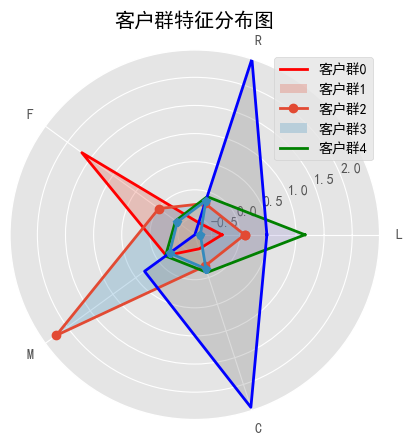

In [26]:
plot(kmeans_model,airline_feature.columns)